# Winequality dataset

## Feim els imports

In [18]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, RFE

from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [19]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [20]:
#CREATE AND MERGE DATAFRAMES
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df = pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [21]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim els valors categòrics en númerics

In [22]:
labelencoder = preprocessing.LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])

Recolocam les columnes

In [23]:
df = df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   int32  
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 685.2 KB


In [25]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5


Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes)

In [26]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)

### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Visualització de les dades

Aquí podem observar les correlacions entre els distints atributs

<AxesSubplot:>

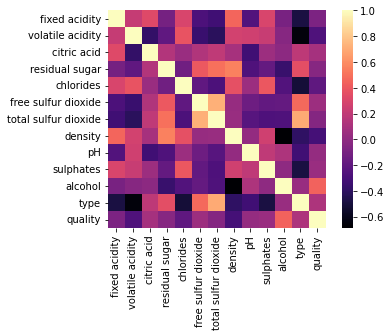

In [28]:
corr = df.corr() #Abs?

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        cmap="magma")

Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

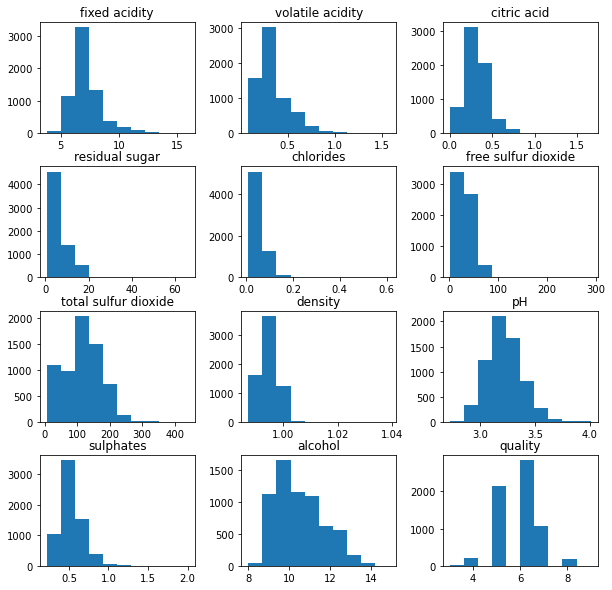

In [29]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)

Gràfic cirular amb el que podem veure la proporció de vi blanc i vermell

1    75.388641
0    24.611359
Name: type, dtype: float64


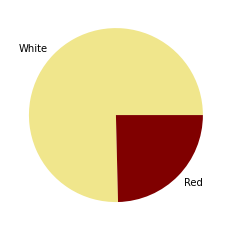

In [30]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts(normalize=True)*100)

# **Classificadors**

Per a cada model imprimim el seu classification report, la precisió de training i la de testing. A més, guardam aquests dos valors dins dos dataframes externs per a després poder comparar les modificacions que farem al dataframe original

Hem decidit fer els models dins funcions per poder cridar-les des de l'apartat de [Enginyeria de característiques/Proves](#Proves) fora haver de reescriure el codi.

In [31]:
dfTrainAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
dfTestAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.56      0.58       440
           6       0.51      0.74      0.60       560
           7       0.50      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.35828362516837
testing accuracy: 53.46153846153846
testing f1score: 53.46153846153846

Confusion Matrix


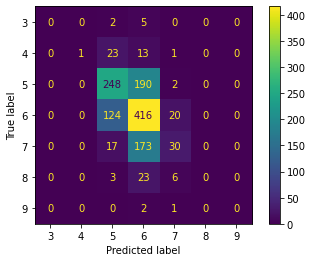

In [32]:
def RegressioLogisitca(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    logreg = LogisticRegression(max_iter=5000)
    logreg.fit(X_train,y_train)

    y_predict = logreg.predict(X_test)
    

    print("\nRegressio Logísitca:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = logreg.score(X_train,y_train)
    testing_accuracy = logreg.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Regressió Logística']=training_accuracy*100
    dfTestAccuracy.at[nom,'Regressió Logística']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()
    
    plt.show()

RegressioLogisitca(df, "Original")

## Perceptró


Perceptró:
              precision    recall  f1-score   support

           3       0.01      0.43      0.01         7
           4       1.00      0.00      0.00        38
           5       0.63      0.08      0.15       440
           6       0.00      0.00      0.00       560
           7       0.30      0.78      0.44       220
           8       0.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.16      1300
   macro avg       0.42      0.18      0.09      1300
weighted avg       0.30      0.16      0.12      1300

training accuracy: 15.239561285356936
testing accuracy: 16.230769230769234
testing f1score: 16.230769230769234

Confusion Matrix


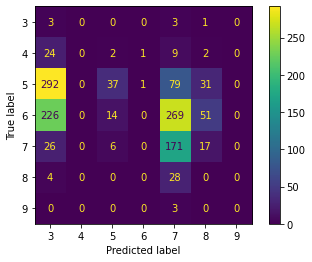

In [33]:
def Perceptro(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    perceptro = Perceptron()
    perceptro.fit(X_train,y_train)

    y_predict = perceptro.predict(X_test)
    
    print("\nPerceptró:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = perceptro.score(X_train,y_train)
    testing_accuracy = perceptro.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Perceptró']=training_accuracy*100
    dfTestAccuracy.at[nom,'Perceptró']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perceptro.classes_), display_labels=perceptro.classes_).plot()
    
    plt.show()

Perceptro(df, "Original")

## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.60      0.08      0.14        38
           5       0.72      0.72      0.72       440
           6       0.63      0.79      0.70       560
           7       0.76      0.51      0.61       220
           8       0.92      0.38      0.53        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.80      0.35      0.39      1300
weighted avg       0.69      0.68      0.66      1300

training accuracy: 97.90263613623245
testing accuracy: 67.84615384615384
testing f1score: 67.84615384615384

Confusion Matrix


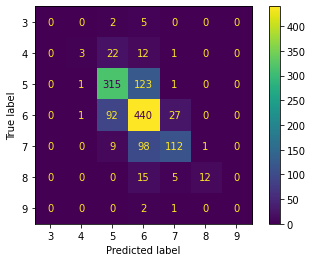

In [34]:
def RandomForest(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(max_depth=14)
    rf.fit(X_train, y_train)

    y_predict=rf.predict(X_test)

    print("\nRandom Forest:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = rf.score(X_train,y_train)
    testing_accuracy = rf.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Random Forest']=training_accuracy*100
    dfTestAccuracy.at[nom,'Random Forest']=testing_accuracy*100
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()  
    plt.show()
           
RandomForest(df, "Original")

## Conclusions


Blablabla

# **Enginyeria de característiques**

L'enginyeria de característiques (feature engineering) és el procés de selecció, extracció, creació i transformació de les característiques d'un dataset amb l'objectiu de millorar l'eficacia d'un model predictiu.

Per a dur a terme l'enginyeria de característiques nosaltres hem duit a terme els següents apartats: 
- **Feature importances dels models**: Ens permet saber la importancia de cada característica dins cada model amb el fi de després eliminar les característiques menys importants
- **Correlacions màximes i mínimes**: Ens permet saber quines caracterísitiques tenen major correlació entre elles. També ens permet saber quines caracteístiques tenen menys correlació amb la qualitat del vi per després poder eliminarles
- **Feature Selection**: Selecció de les característiques més i menys importantes. Nosaltres implementarem els:
   1. Sequential Feature Selection
   2. Univariate Feature Selection amb Kbest
   3. Recursive Feature Elimination

## Feature importances de cada model

In [35]:
dfWquality=df.drop("quality", axis=1)

### Regressió logística <a id='Regressio-Logistica'></a>

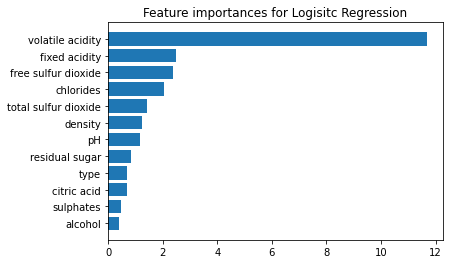

In [36]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

logreg_odds = np.exp(logreg.coef_[0])
indices=np.argsort(logreg_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Logisitc Regression")
ax.barh(range(len(logreg_odds)), logreg_odds[indices])
ax.set_yticks(range(len(logreg_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Perceptró <a id='Perceptro'></a>

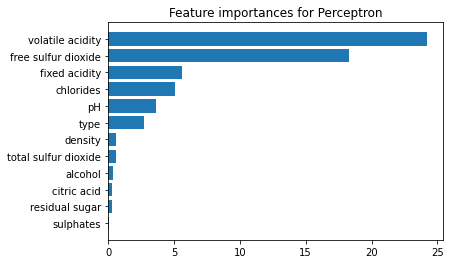

In [37]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

perceptron_odds = np.exp(perceptron.coef_[0])
indices=np.argsort(perceptron_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Perceptron")
ax.barh(range(len(perceptron_odds)), perceptron_odds[indices])
ax.set_yticks(range(len(perceptron_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Random Forest <a id='Random-Forest'></a>

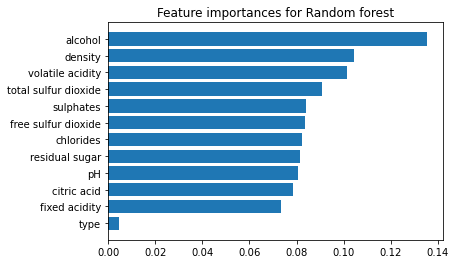

In [38]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

importancesRF = rf.feature_importances_
indices = np.argsort(importancesRF)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Random forest")
ax.barh(range(len(importancesRF)), importancesRF[indices])
ax.set_yticks(range(len(importancesRF)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### 
| Model | Millor característica | Pitjor característica |
| ----------- | ----------- | ----------- |
| Regressió Logística | Volatile Acidity | Alcohol |
| Perceptró | Free Sulphure Dioxide | Sulphates |
| Random Forest | Alcohol | Type |

És curiós que la pitjor característica de la regressió logística sigui la millor del Random forest

Els resultats poden variar depenent de la execució, aquests valors son els obtinguts a una execució

## Correlacions màximes i mínimes <a id='Correlacions-Minimes'></a>

In [39]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print(so[13:23]) #Les 12 primeres son autocorrelacions
print("-------------")
print(so['quality'][8:13])


free sulfur dioxide   total sulfur dioxide    0.720934
total sulfur dioxide  free sulfur dioxide     0.720934
type                  total sulfur dioxide    0.700357
total sulfur dioxide  type                    0.700357
density               alcohol                 0.686745
alcohol               density                 0.686745
volatile acidity      type                    0.653036
type                  volatile acidity        0.653036
residual sugar        density                 0.552517
density               residual sugar          0.552517
dtype: float64
-------------
free sulfur dioxide     0.055463
total sulfur dioxide    0.041385
sulphates               0.038485
residual sugar          0.036980
pH                      0.019506
dtype: float64


Les característiques amb major correlació son el *Free sulfur dioxide* i el *Total sulfur dioxide*\
Les característiques amb menor correlació amb la qualitat son el *pH*, *residual sugars* i *sulphates*

## [Feature Selection](https://www.scikit-learn.org/stable/modules/feature_selection.html)

### [Sequential Feature Selector](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) <a id='Sequential-Feature-Selector'></a>


In [40]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [41]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X_train, y_train)


sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="backward"
).fit(X_train, y_train)


print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_forward.get_support()])}\n"
)

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_backward.get_support()])}"
)

Features selected by forward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: Index(['chlorides', 'citric acid'], dtype='object')

Features selected by backward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: Index(['chlorides', 'citric acid'], dtype='object')


### [Univariate Feature selection with Kbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) <a id='Univariate-feature-selection'></a> 


In [42]:
mask = SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()
best_features = dfWquality.columns[mask]
worst_features = dfWquality.columns.difference(best_features)
print("Best features", best_features)
print("Worst features", worst_features)


Best features Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol', 'type'],
      dtype='object')
Worst features Index(['pH', 'residual sugar'], dtype='object')


### [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <a id='Recursive-feature-elimination'></a> 


In [43]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [44]:
rfe_selector = RFE(ridge, n_features_to_select=10).fit(X_train, y_train)

print(
    "Features selected by recursive feature elimination: "
    f"{feature_names[rfe_selector.get_support()]}"
    "\nFeatures not selected by recursive feature elimination: "
    f"{dfWquality.columns.difference(feature_names[rfe_selector.get_support()])}\n"
)

Features selected by recursive feature elimination: ['fixed acidity' 'volatile acidity' 'residual sugar' 'chlorides'
 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates'
 'alcohol']
Features not selected by recursive feature elimination: Index(['citric acid', 'type'], dtype='object')



### 
| Tipus | 1ra Pitjor Caract. | 2na Pitjor Caract.|
| ----------- | ----------- | ----------- |
| Sequential Feature Selection - Forward| Free sulfur dioxide | Total sulfur dioxide |
| Sequential Feature Selection - backward| Chloride | Citric Acid |
| Univariate Feature Selection | pH | Sulphates |
| Recursive Feature Elimination | Citric Acid | Type |

## Proves <a id='Proves'></a>

### Eliminam features

#### Fora alcohol

Provam de llevar la característica de l'*alcohol* ja que com hem vist [aquí](#Regressio-Logistica), el Feature Selection de la Regressio Logístic ens diu que és la característica amb menys importancia


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.55      0.42      0.48       440
           6       0.47      0.80      0.59       560
           7       0.17      0.00      0.01       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.49      1300
   macro avg       0.74      0.18      0.16      1300
weighted avg       0.48      0.49      0.42      1300

training accuracy: 51.06792380219357
testing accuracy: 49.0
testing f1score: 49.0

Confusion Matrix


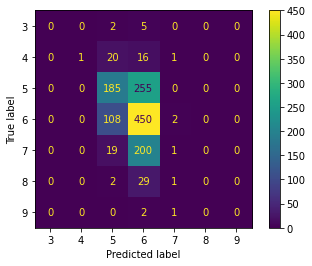


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.38      0.13      0.20        38
           5       0.57      0.14      0.23       440
           6       0.43      0.19      0.26       560
           7       0.55      0.03      0.05       220
           8       0.50      0.03      0.06        32
           9       0.00      1.00      0.01         3

    accuracy                           0.14      1300
   macro avg       0.35      0.22      0.11      1300
weighted avg       0.49      0.14      0.21      1300

training accuracy: 14.893207619780643
testing accuracy: 14.153846153846153
testing f1score: 14.153846153846153

Confusion Matrix


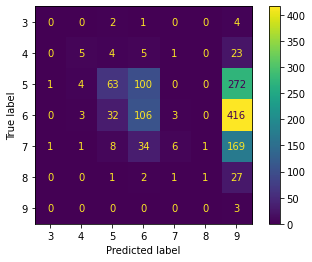


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.50      0.08      0.14        38
           5       0.71      0.70      0.70       440
           6       0.63      0.80      0.71       560
           7       0.80      0.50      0.62       220
           8       0.86      0.38      0.52        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.79      0.35      0.38      1300
weighted avg       0.69      0.68      0.66      1300

training accuracy: 98.13353857994997
testing accuracy: 67.76923076923077
testing f1score: 67.76923076923077

Confusion Matrix


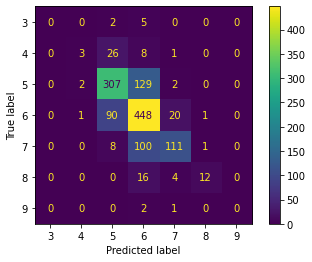

In [45]:
dfWalcohol = df.drop('alcohol',axis=1)

RegressioLogisitca(dfWalcohol, "Fora alcohol")
Perceptro(dfWalcohol, "Fora alcohol")
RandomForest(dfWalcohol, "Fora alcohol")

#### Fora sulphates

Provam de llevar la característica de sulphates ja que com hem vist [aquí](#Perceptro), el Feature Selection del Perceptro ens diu que és la característica amb menys importancia


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.57      0.58       440
           6       0.50      0.72      0.59       560
           7       0.49      0.11      0.18       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.48      1300

training accuracy: 53.99268808928228
testing accuracy: 52.53846153846153
testing f1score: 52.53846153846153

Confusion Matrix


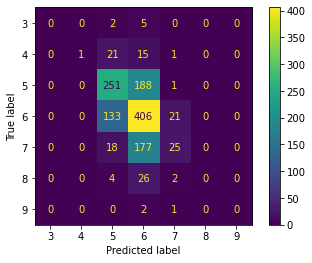


Perceptró:
              precision    recall  f1-score   support

           3       0.01      0.14      0.02         7
           4       1.00      0.00      0.00        38
           5       0.59      0.56      0.57       440
           6       0.55      0.29      0.38       560
           7       0.38      0.65      0.48       220
           8       1.00      0.00      0.00        32
           9       0.00      0.00      0.00         3

    accuracy                           0.43      1300
   macro avg       0.50      0.23      0.21      1300
weighted avg       0.55      0.43      0.44      1300

training accuracy: 41.100634981720226
testing accuracy: 42.53846153846153
testing f1score: 42.53846153846153

Confusion Matrix


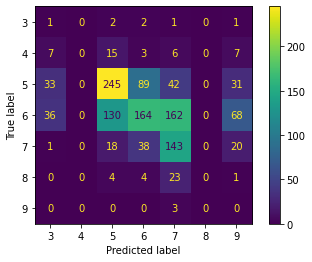


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.57      0.11      0.18        38
           5       0.69      0.70      0.70       440
           6       0.63      0.77      0.69       560
           7       0.75      0.51      0.61       220
           8       0.87      0.41      0.55        32
           9       1.00      0.00      0.00         3

    accuracy                           0.67      1300
   macro avg       0.79      0.36      0.39      1300
weighted avg       0.68      0.67      0.66      1300

training accuracy: 97.69097556282472
testing accuracy: 66.76923076923077
testing f1score: 66.76923076923077

Confusion Matrix


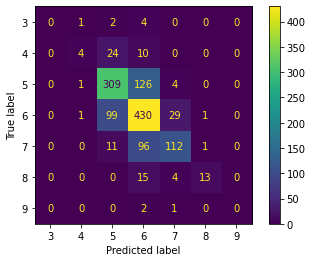

In [46]:
dfWsulphates = df.drop('sulphates',axis=1)

RegressioLogisitca(dfWsulphates, "Fora sulphates")
Perceptro(dfWsulphates, "Fora sulphates")
RandomForest(dfWsulphates, "Fora sulphates")

#### Fora type

Provam de llevar la característica de Type ja que com hem vist [aquí](#Random-Forest), el Feature Selection del Random Forest ens diu que és la característica amb menys importancia


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.59      0.56      0.58       440
           6       0.50      0.75      0.60       560
           7       0.51      0.12      0.20       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.20      0.20      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.28131614392919
testing accuracy: 53.307692307692314
testing f1score: 53.307692307692314

Confusion Matrix


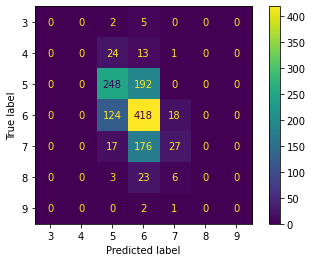


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00       440
           6       0.44      0.95      0.60       560
           7       0.51      0.19      0.28       220
           8       1.00      0.00      0.00        32
           9       0.00      0.00      0.00         3

    accuracy                           0.44      1300
   macro avg       0.28      0.16      0.13      1300
weighted avg       0.30      0.44      0.31      1300

training accuracy: 44.41023667500481
testing accuracy: 44.0
testing f1score: 44.0

Confusion Matrix


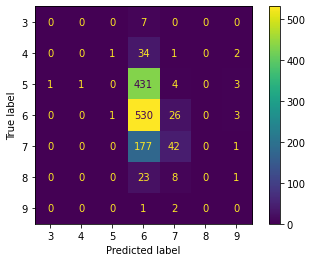


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.50      0.11      0.17        38
           5       0.71      0.71      0.71       440
           6       0.63      0.78      0.69       560
           7       0.76      0.49      0.60       220
           8       0.93      0.41      0.57        32
           9       1.00      0.00      0.00         3

    accuracy                           0.67      1300
   macro avg       0.79      0.36      0.39      1300
weighted avg       0.68      0.67      0.66      1300

training accuracy: 98.0565710987108
testing accuracy: 67.23076923076923
testing f1score: 67.23076923076923

Confusion Matrix


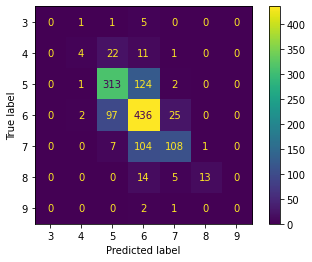

In [47]:
dfWtype = df.drop('type',axis=1)

RegressioLogisitca(dfWtype, "Fora type")
Perceptro(dfWtype, "Fora type")
RandomForest(dfWtype, "Fora type")

#### Fora pH, sulfats i sucres residuals

Provam de llevar les característiques del pH, els sulfats i els sucres residuals ja que com hem vist [aquí](#Correlacions-Minimes), son les tres característiques menys correlacionades amb la qualitat.


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.57      0.57      0.57       440
           6       0.49      0.71      0.58       560
           7       0.48      0.10      0.17       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.52      1300
   macro avg       0.79      0.20      0.20      1300
weighted avg       0.55      0.52      0.47      1300

training accuracy: 53.43467385029825
testing accuracy: 51.84615384615384
testing f1score: 51.84615384615384

Confusion Matrix


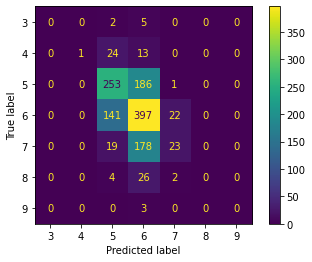


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.12      0.26      0.17        38
           5       1.00      0.01      0.02       440
           6       0.44      0.89      0.59       560
           7       0.50      0.07      0.12       220
           8       0.02      0.03      0.03        32
           9       1.00      0.00      0.00         3

    accuracy                           0.41      1300
   macro avg       0.58      0.18      0.13      1300
weighted avg       0.62      0.41      0.29      1300

training accuracy: 40.273234558399075
testing accuracy: 40.69230769230769
testing f1score: 40.69230769230769

Confusion Matrix


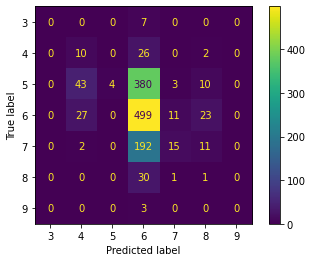


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.71      0.13      0.22        38
           5       0.70      0.69      0.69       440
           6       0.62      0.77      0.69       560
           7       0.75      0.50      0.60       220
           8       0.92      0.38      0.53        32
           9       1.00      0.00      0.00         3

    accuracy                           0.66      1300
   macro avg       0.82      0.35      0.39      1300
weighted avg       0.68      0.66      0.65      1300

training accuracy: 97.383105637868
testing accuracy: 66.38461538461539
testing f1score: 66.38461538461539

Confusion Matrix


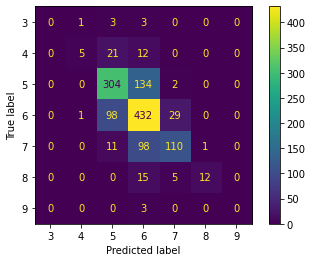

In [48]:
dfWpH_Sulf_ResSug = df.drop('pH',axis=1)
dfWpH_Sulf_ResSug = dfWpH_Sulf_ResSug.drop('sulphates',axis=1)
dfWpH_Sulf_ResSug = dfWpH_Sulf_ResSug.drop('residual sugar',axis=1)

RegressioLogisitca(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")
Perceptro(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")
RandomForest(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")

#### Fora free sulfur dioxide i total sulfur dioxide

Provam de llevar les característiques del free and total sulfur dioxide acid ja que com hem vist [aquí](#Sequential-Feature-Selector), ja que el Forward Feature Selection ens ha dit que son les dues pitjors característiques 


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.57      0.58       440
           6       0.50      0.73      0.60       560
           7       0.53      0.14      0.22       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.242832403309606
testing accuracy: 53.15384615384615
testing f1score: 53.15384615384615

Confusion Matrix


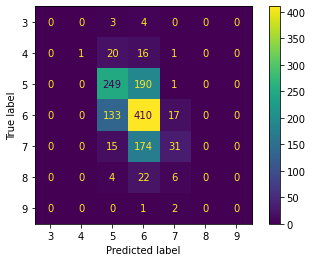


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.00      0.00      0.00        38
           5       0.50      0.02      0.04       440
           6       0.44      0.82      0.57       560
           7       1.00      0.00      0.01       220
           8       0.06      0.44      0.11        32
           9       1.00      0.00      0.00         3

    accuracy                           0.37      1300
   macro avg       0.57      0.18      0.10      1300
weighted avg       0.54      0.37      0.26      1300

training accuracy: 38.13738695401193
testing accuracy: 37.38461538461538
testing f1score: 37.38461538461538

Confusion Matrix


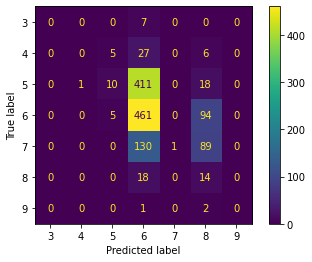


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.60      0.08      0.14        38
           5       0.71      0.70      0.71       440
           6       0.62      0.78      0.69       560
           7       0.75      0.48      0.59       220
           8       0.81      0.41      0.54        32
           9       1.00      0.00      0.00         3

    accuracy                           0.67      1300
   macro avg       0.78      0.35      0.38      1300
weighted avg       0.68      0.67      0.65      1300

training accuracy: 97.69097556282472
testing accuracy: 66.76923076923077
testing f1score: 66.76923076923077

Confusion Matrix


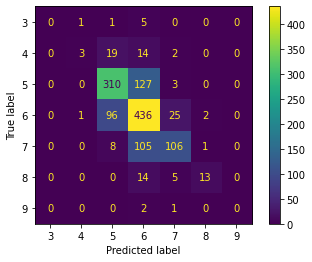

In [49]:
dfWSO2 = df.drop('free sulfur dioxide',axis=1)
dfWSO2 = dfWSO2.drop('total sulfur dioxide',axis=1)

RegressioLogisitca(dfWSO2, "Fora SO2")
Perceptro(dfWSO2, "Fora SO2")
RandomForest(dfWSO2, "Fora SO2")

#### Fora chloride i citric acid

Provam de llevar les característiques del chloride i citric acid ja que com hem vist [aquí](#Sequential-Feature-Selector), el Backward Feature Selection ens ha dit que son les dues pitjors característiques 


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.56      0.57       440
           6       0.50      0.74      0.60       560
           7       0.52      0.14      0.22       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.33904175485858
testing accuracy: 53.230769230769226
testing f1score: 53.230769230769226

Confusion Matrix


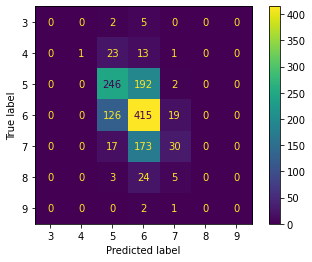


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.00      0.00      0.00        38
           5       0.36      0.97      0.53       440
           6       0.40      0.03      0.06       560
           7       0.52      0.11      0.19       220
           8       1.00      0.00      0.00        32
           9       0.00      0.00      0.00         3

    accuracy                           0.36      1300
   macro avg       0.47      0.16      0.11      1300
weighted avg       0.41      0.36      0.24      1300

training accuracy: 36.444102366750045
testing accuracy: 36.38461538461538
testing f1score: 36.38461538461538

Confusion Matrix


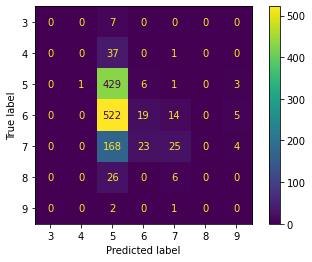


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.50      0.08      0.14        38
           5       0.71      0.72      0.71       440
           6       0.64      0.76      0.69       560
           7       0.73      0.53      0.61       220
           8       0.78      0.44      0.56        32
           9       1.00      0.00      0.00         3

    accuracy                           0.67      1300
   macro avg       0.77      0.36      0.39      1300
weighted avg       0.68      0.67      0.66      1300

training accuracy: 97.67173369251492
testing accuracy: 67.46153846153847
testing f1score: 67.46153846153847

Confusion Matrix


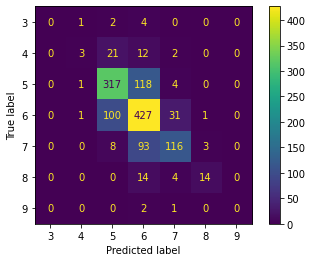

In [50]:
dfWchlo_CA = df.drop('chlorides',axis=1)
dfWchlo_CA = dfWchlo_CA.drop('citric acid',axis=1)

RegressioLogisitca(dfWchlo_CA, "Fora chlo_CA")
Perceptro(dfWchlo_CA, "Fora chlo_CA")
RandomForest(dfWchlo_CA, "Fora chlo_CA")

#### Fora pH i sulfats

Provam de llevar les característiques del pH i dels sulfats ja que com hem vist [aquí](#Univariate-feature-selection), el SelectKBest ens ha dit que son les dues pitjors característiques 


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.58      0.57      0.57       440
           6       0.50      0.72      0.59       560
           7       0.49      0.12      0.19       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.52      1300
   macro avg       0.80      0.20      0.20      1300
weighted avg       0.55      0.52      0.48      1300

training accuracy: 53.47315759091784
testing accuracy: 52.38461538461539
testing f1score: 52.38461538461539

Confusion Matrix


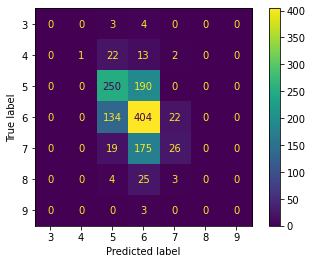


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.43      0.08      0.13        38
           5       0.67      0.00      0.01       440
           6       0.44      0.85      0.58       560
           7       0.46      0.12      0.19       220
           8       0.08      0.28      0.12        32
           9       1.00      0.00      0.00         3

    accuracy                           0.40      1300
   macro avg       0.44      0.19      0.15      1300
weighted avg       0.51      0.40      0.29      1300

training accuracy: 40.273234558399075
testing accuracy: 39.76923076923077
testing f1score: 39.76923076923077

Confusion Matrix


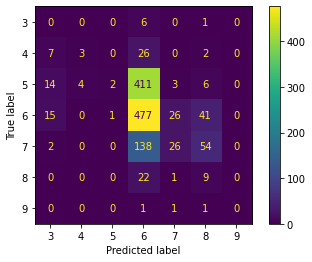


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.40      0.05      0.09        38
           5       0.70      0.72      0.71       440
           6       0.64      0.77      0.70       560
           7       0.77      0.53      0.63       220
           8       0.93      0.41      0.57        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.78      0.35      0.38      1300
weighted avg       0.68      0.68      0.66      1300

training accuracy: 97.7487011737541
testing accuracy: 67.6923076923077
testing f1score: 67.6923076923077

Confusion Matrix


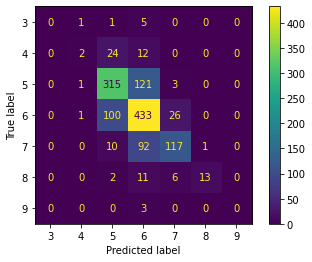

In [51]:
dfWpH_Sulf = df.drop('pH',axis=1)
dfWpH_Sulf = dfWpH_Sulf.drop('sulphates',axis=1)

RegressioLogisitca(dfWpH_Sulf, "Fora pH_Sulf")
Perceptro(dfWpH_Sulf, "Fora pH_Sulf")
RandomForest(dfWpH_Sulf, "Fora pH_Sulf")

#### Fora citric acid i type

Provam de llevar les característiques de l'àcid cítric i el type ja que com hem vist [aquí](#Recursive-feature-elimination), el Recursive Feature Elimination ens ha dit que son les dues pitjors característiques 


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.59      0.56      0.58       440
           6       0.51      0.75      0.61       560
           7       0.54      0.13      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.54      1300
   macro avg       0.81      0.21      0.20      1300
weighted avg       0.57      0.54      0.49      1300

training accuracy: 54.242832403309606
testing accuracy: 53.61538461538462
testing f1score: 53.61538461538462

Confusion Matrix


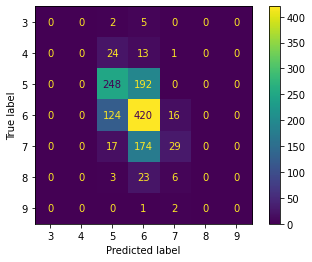


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.58      0.52      0.55       440
           6       0.52      0.51      0.52       560
           7       1.00      0.00      0.00       220
           8       0.06      0.69      0.11        32
           9       1.00      0.00      0.00         3

    accuracy                           0.41      1300
   macro avg       0.74      0.25      0.17      1300
weighted avg       0.63      0.41      0.41      1300

training accuracy: 41.08139311141043
testing accuracy: 41.38461538461539
testing f1score: 41.38461538461539

Confusion Matrix


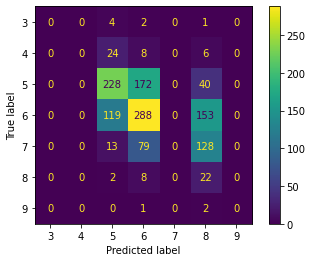


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.57      0.11      0.18        38
           5       0.71      0.73      0.72       440
           6       0.63      0.76      0.69       560
           7       0.73      0.52      0.61       220
           8       0.77      0.31      0.44        32
           9       1.00      0.00      0.00         3

    accuracy                           0.67      1300
   macro avg       0.77      0.35      0.38      1300
weighted avg       0.68      0.67      0.66      1300

training accuracy: 97.57552434096594
testing accuracy: 67.07692307692308
testing f1score: 67.07692307692308

Confusion Matrix


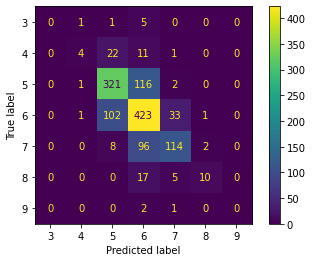

In [52]:
dfWCA_Type = df.drop('citric acid',axis=1)
dfWCA_Type = dfWCA_Type.drop('type',axis=1)

RegressioLogisitca(dfWCA_Type, "Fora CA_Type")
Perceptro(dfWCA_Type, "Fora CA_Type")
RandomForest(dfWCA_Type, "Fora CA_Type")

### Cream features

#### Acids totals


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.56      0.58       440
           6       0.51      0.74      0.60       560
           7       0.50      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.43525110640755
testing accuracy: 53.46153846153846
testing f1score: 53.46153846153846

Confusion Matrix


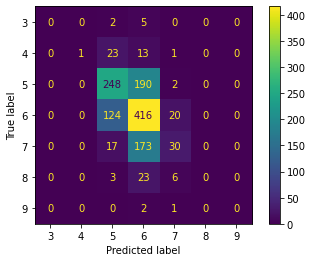


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.37      0.96      0.54       440
           6       1.00      0.00      0.01       560
           7       0.41      0.28      0.33       220
           8       0.21      0.12      0.16        32
           9       1.00      0.00      0.00         3

    accuracy                           0.38      1300
   macro avg       0.71      0.19      0.15      1300
weighted avg       0.67      0.38      0.24      1300

training accuracy: 37.04060034635366
testing accuracy: 37.61538461538462
testing f1score: 37.61538461538462

Confusion Matrix


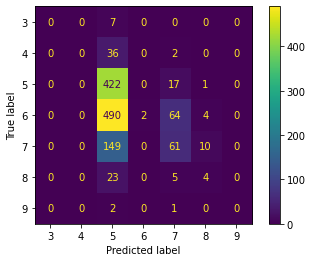


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.60      0.08      0.14        38
           5       0.72      0.72      0.72       440
           6       0.63      0.79      0.70       560
           7       0.79      0.51      0.62       220
           8       0.86      0.38      0.52        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.80      0.35      0.39      1300
weighted avg       0.70      0.68      0.67      1300

training accuracy: 98.13353857994997
testing accuracy: 68.07692307692308
testing f1score: 68.07692307692308

Confusion Matrix


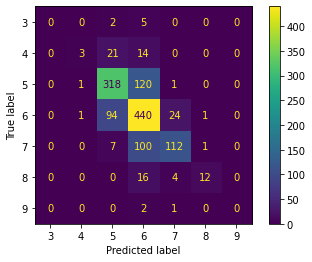

In [53]:
combinator_Acid_Tot = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum'],
    new_variables_names = ['total_acidity']
)

df_Acid_Tot = combinator_Acid_Tot.fit_transform(df)

RegressioLogisitca(df_Acid_Tot, "Acid Totals")
Perceptro(df_Acid_Tot, "Acid Totals")
RandomForest(df_Acid_Tot, "Acid Totals")

#### Percentatge de Acid cítric respecte a l'acidesa fixada


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.60      0.57      0.58       440
           6       0.51      0.74      0.60       560
           7       0.50      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.54      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.54      0.49      1300

training accuracy: 54.47373484702713
testing accuracy: 53.61538461538462
testing f1score: 53.61538461538462

Confusion Matrix


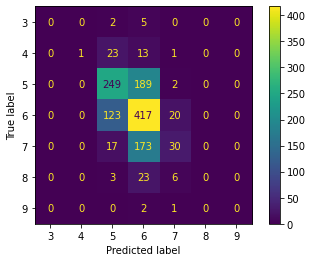


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.64      0.38      0.48       440
           6       0.48      0.88      0.62       560
           7       1.00      0.00      0.00       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.51      1300
   macro avg       0.87      0.18      0.16      1300
weighted avg       0.65      0.51      0.43      1300

training accuracy: 51.79911487396575
testing accuracy: 50.84615384615384
testing f1score: 50.84615384615384

Confusion Matrix


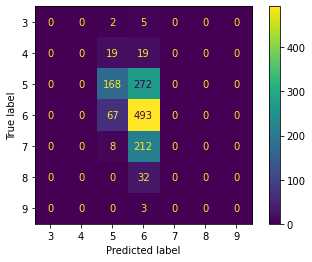


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.67      0.11      0.18        38
           5       0.72      0.70      0.71       440
           6       0.64      0.80      0.71       560
           7       0.80      0.55      0.65       220
           8       0.80      0.38      0.51        32
           9       1.00      0.00      0.00         3

    accuracy                           0.69      1300
   macro avg       0.80      0.36      0.40      1300
weighted avg       0.70      0.69      0.67      1300

training accuracy: 97.99884548778141
testing accuracy: 68.61538461538461
testing f1score: 68.61538461538461

Confusion Matrix


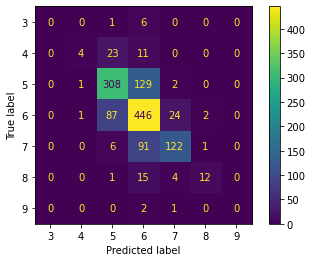

In [54]:
combinator_PercAC = CombineWithReferenceFeature(
    variables_to_combine=['citric acid'],
    reference_variables=['fixed acidity'],
    operations=['div'],   
    new_variables_names=['percentage_citric_acid'])

df_PercAC = combinator_PercAC.fit_transform(df)

RegressioLogisitca(df_PercAC, "Perc. acid citric")
Perceptro(df_PercAC, "Perc. acid citric")
RandomForest(df_PercAC, "Perc. acid citric")

#### Minerals totals


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.60      0.57      0.58       440
           6       0.51      0.74      0.60       560
           7       0.50      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.54      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.54      0.49      1300

training accuracy: 54.53146045795651
testing accuracy: 53.53846153846153
testing f1score: 53.53846153846153

Confusion Matrix


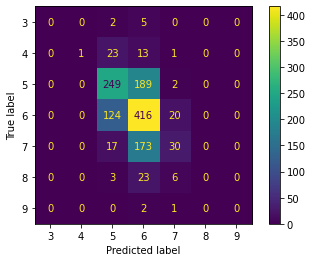


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.21      0.11      0.14        38
           5       0.42      0.92      0.58       440
           6       0.49      0.07      0.13       560
           7       0.44      0.45      0.44       220
           8       0.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.42      1300
   macro avg       0.51      0.22      0.18      1300
weighted avg       0.44      0.42      0.33      1300

training accuracy: 41.5047142582259
testing accuracy: 42.07692307692308
testing f1score: 42.07692307692308

Confusion Matrix


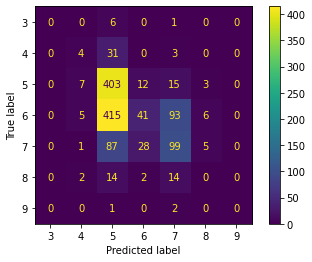


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.57      0.11      0.18        38
           5       0.71      0.72      0.72       440
           6       0.63      0.78      0.70       560
           7       0.76      0.50      0.60       220
           8       0.93      0.44      0.60        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.80      0.36      0.40      1300
weighted avg       0.69      0.68      0.66      1300

training accuracy: 98.21050606118915
testing accuracy: 67.6923076923077
testing f1score: 67.6923076923077

Confusion Matrix


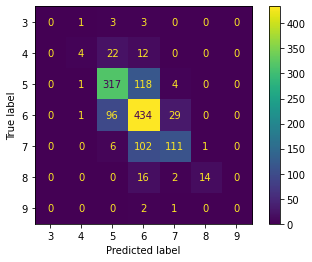

In [55]:
combinator_Minerals_Totals = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

df_Minerals_Totals = combinator_Minerals_Totals.fit_transform(df)

RegressioLogisitca(df_Minerals_Totals, "Minerals totals")
Perceptro(df_Minerals_Totals, "Minerals totals")
RandomForest(df_Minerals_Totals, "Minerals totals")

#### Percentatge de Diòxid de sofre lliure


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.56      0.58       440
           6       0.51      0.74      0.60       560
           7       0.48      0.13      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 55.05099095632096
testing accuracy: 53.230769230769226
testing f1score: 53.230769230769226

Confusion Matrix


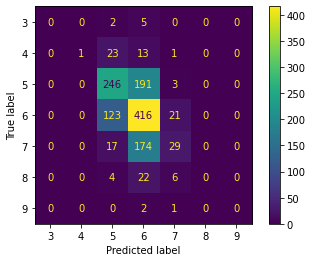


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.42      0.80      0.55       440
           6       0.46      0.33      0.38       560
           7       0.51      0.15      0.23       220
           8       0.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.44      1300
   macro avg       0.63      0.18      0.17      1300
weighted avg       0.47      0.44      0.39      1300

training accuracy: 45.295362709255336
testing accuracy: 43.69230769230769
testing f1score: 43.69230769230769

Confusion Matrix


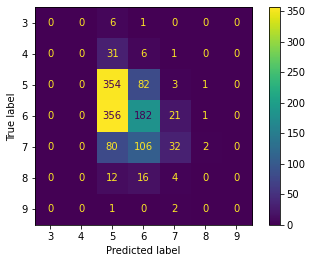


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.57      0.11      0.18        38
           5       0.72      0.72      0.72       440
           6       0.64      0.78      0.70       560
           7       0.78      0.54      0.64       220
           8       0.93      0.41      0.57        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.80      0.36      0.40      1300
weighted avg       0.70      0.68      0.67      1300

training accuracy: 97.80642678468348
testing accuracy: 68.3076923076923
testing f1score: 68.3076923076923

Confusion Matrix


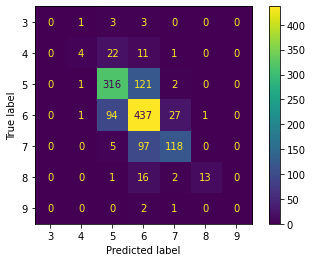

In [56]:
combinator_PercSO2 = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],   
    new_variables_names=['percentage_free_sulfur'])

df_PercSO2 = combinator_PercSO2.fit_transform(df)

RegressioLogisitca(df_PercSO2, "Perc. SO2 lliure")
Perceptro(df_PercSO2, "Perc. SO2 lliure")
RandomForest(df_PercSO2, "Perc. SO2 lliure")

#### Diòxid de sofre no lliure


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.60      0.57      0.58       440
           6       0.51      0.74      0.60       560
           7       0.48      0.13      0.20       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.5699441985761
testing accuracy: 53.38461538461539
testing f1score: 53.38461538461539

Confusion Matrix


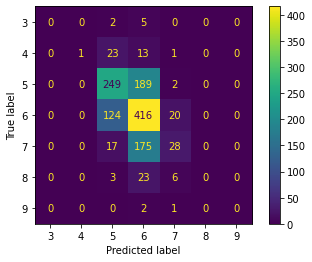


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.41      0.91      0.56       440
           6       0.50      0.15      0.23       560
           7       0.41      0.27      0.32       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.42      1300
   macro avg       0.76      0.19      0.16      1300
weighted avg       0.49      0.42      0.34      1300

training accuracy: 43.23648258610737
testing accuracy: 41.92307692307693
testing f1score: 41.92307692307693

Confusion Matrix


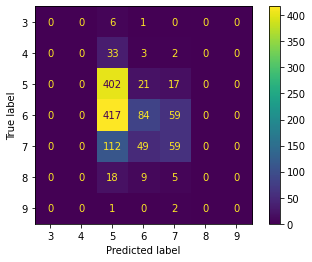


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.33      0.05      0.09        38
           5       0.72      0.71      0.71       440
           6       0.63      0.79      0.70       560
           7       0.79      0.52      0.62       220
           8       0.92      0.38      0.53        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.77      0.35      0.38      1300
weighted avg       0.69      0.68      0.66      1300

training accuracy: 97.76794304406388
testing accuracy: 67.76923076923077
testing f1score: 67.76923076923077

Confusion Matrix


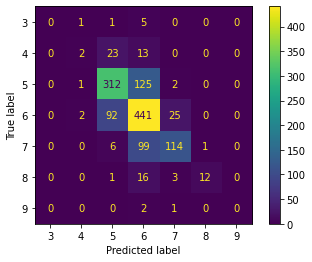

In [57]:
combinator_No_FreeSO2 = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

df_No_FreeSO2 = combinator_No_FreeSO2.fit_transform(df)

RegressioLogisitca(df_No_FreeSO2, "S02 no lliure")
Perceptro(df_No_FreeSO2, "S02 no lliure")
RandomForest(df_No_FreeSO2, "S02 no lliure")


#### Dels diòxid de sofre quin percentatge és una sal


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.03      0.05        38
           5       0.59      0.56      0.58       440
           6       0.51      0.74      0.60       560
           7       0.50      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       1.00      0.00      0.00         3

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.37752549547816
testing accuracy: 53.38461538461539
testing f1score: 53.38461538461539

Confusion Matrix


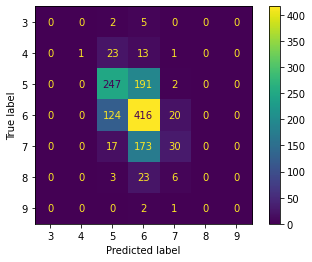


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.54      0.26      0.35       440
           6       0.45      0.81      0.58       560
           7       0.42      0.14      0.21       220
           8       1.00      0.00      0.00        32
           9       0.00      0.00      0.00         3

    accuracy                           0.46      1300
   macro avg       0.63      0.17      0.16      1300
weighted avg       0.51      0.46      0.40      1300

training accuracy: 47.835289590148165
testing accuracy: 46.23076923076923
testing f1score: 46.23076923076923

Confusion Matrix


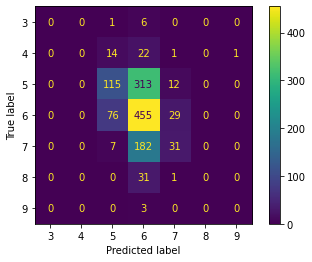


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.57      0.11      0.18        38
           5       0.71      0.72      0.72       440
           6       0.64      0.79      0.71       560
           7       0.78      0.51      0.62       220
           8       0.93      0.44      0.60        32
           9       1.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.81      0.37      0.40      1300
weighted avg       0.70      0.68      0.67      1300

training accuracy: 97.99884548778141
testing accuracy: 68.38461538461539
testing f1score: 68.38461538461539

Confusion Matrix


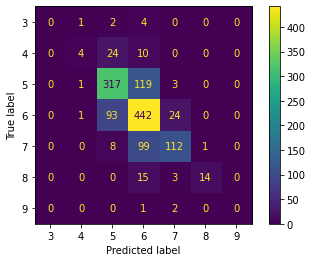

In [58]:
combinator_Sulfurs_Sals = CombineWithReferenceFeature(
    variables_to_combine=['sulphates'],
    reference_variables=['free sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_salt_sulfur']
)

df_Sulfurs_Sals = combinator_Sulfurs_Sals.fit_transform(df)

RegressioLogisitca(df_Sulfurs_Sals, "Sulfurs Sals")
Perceptro(df_Sulfurs_Sals, "Sulfurs Sals")
RandomForest(df_Sulfurs_Sals, "Sulfurs Sals")


#### Unim totes les creacions

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
367            10.4             0.575         0.61            2.60      0.076   
111             7.2             0.270         0.46           18.75      0.052   
2809            5.8             0.320         0.31            2.70      0.049   
3370            6.0             0.290         0.25            1.40      0.033   
3477            7.6             0.310         0.24            1.80      0.037   
...             ...               ...          ...             ...        ...   
1677            7.3             0.230         0.37            1.80      0.032   
1951            9.9             1.005         0.46            1.40      0.046   
628             8.7             0.540         0.26            2.50      0.097   
2246            6.4             0.340         0.20           14.90      0.060   
1087            7.9             0.190         0.42            1.60      0.057   

      free sulfur dioxide  

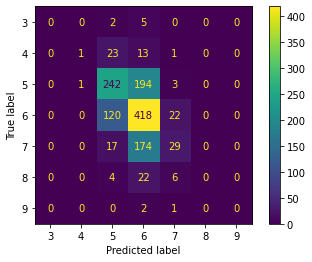


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        38
           5       0.38      0.95      0.55       440
           6       0.67      0.00      0.01       560
           7       0.42      0.39      0.41       220
           8       0.33      0.03      0.06        32
           9       1.00      0.00      0.00         3

    accuracy                           0.39      1300
   macro avg       0.69      0.20      0.15      1300
weighted avg       0.53      0.39      0.26      1300

training accuracy: 38.59919184144699
testing accuracy: 39.0
testing f1score: 39.0

Confusion Matrix


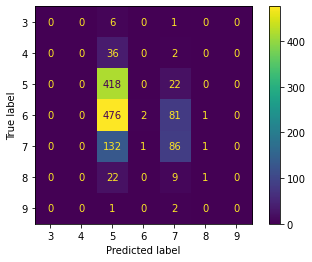


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.71      0.13      0.22        38
           5       0.73      0.72      0.72       440
           6       0.64      0.79      0.71       560
           7       0.79      0.55      0.65       220
           8       0.93      0.41      0.57        32
           9       1.00      0.00      0.00         3

    accuracy                           0.69      1300
   macro avg       0.83      0.37      0.41      1300
weighted avg       0.71      0.69      0.68      1300

training accuracy: 98.44140850490668
testing accuracy: 69.23076923076923
testing f1score: 69.23076923076923

Confusion Matrix


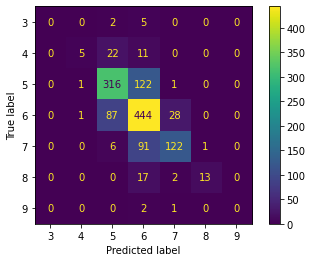

In [59]:
df_Unió = combinator_Acid_Tot.fit_transform(df)
df_Unió = combinator_Minerals_Totals.fit_transform(df_Unió)
df_Unió = combinator_PercAC.fit_transform(df_Unió)
df_Unió = combinator_No_FreeSO2.fit_transform(df_Unió)
df_Unió = combinator_PercSO2.fit_transform(df_Unió)
df_Unió = combinator_Sulfurs_Sals.fit_transform(df_Unió)

print(df_Unió)
RegressioLogisitca(df_Unió, "Totes creacions")
Perceptro(df_Unió, "Totes creacions")
RandomForest(df_Unió, "Totes creacions")

### Comparam les precisions

In [60]:
print("Training accuracy for each model and each dataframe\n", dfTrainAccuracy)
print("\nTesting accuracy for each model and each dataframe\n", dfTestAccuracy)

Training accuracy for each model and each dataframe
                     Regressió Logística  Perceptró Random Forest
Original                      54.358284  15.239561     97.902636
Fora alcohol                  51.067924  14.893208     98.133539
Fora sulphates                53.992688  41.100635     97.690976
Fora type                     54.281316  44.410237     98.056571
Fora pH_Sulf_ResSug           53.434674  40.273235     97.383106
Fora SO2                      54.242832  38.137387     97.690976
Fora chlo_CA                  54.339042  36.444102     97.671734
Fora pH_Sulf                  53.473158  40.273235     97.748701
Fora CA_Type                  54.242832  41.081393     97.575524
Acid Totals                   54.435251    37.0406     98.133539
Perc. acid citric             54.473735  51.799115     97.998845
Minerals totals                54.53146  41.504714     98.210506
Perc. SO2 lliure              55.050991  45.295363     97.806427
S02 no lliure                 54.5699

# **Grid Search CV**